In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Описание набора данных

In [201]:
print(fetch_california_housing().DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

## Создание дата фрейма для отображение результатов

In [202]:
result_df = pd.DataFrame(columns=['model_name', 'RMSE', 'R2', 'COLUMNS'])

## 1. Загрузка данных

In [203]:
dataset = fetch_california_housing(as_frame=True)
house_df = pd.concat([dataset.data, dataset.target], axis=1)
house_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## 2. Проверка на пропуски

In [204]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


> Как мы видим пропусков нет.

## 3. Модель на необработанных данных

In [205]:
def get_metrics(df, model_name=''):
    X = df.drop('MedHouseVal', axis=1)
    y = df['MedHouseVal']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    linear_reg_model = LinearRegression().fit(X_train, y_train)
    
    y_true_train = y_train
    y_true_test = y_test

    y_pred_train = linear_reg_model.predict(X_train)
    y_pred_test = linear_reg_model.predict(X_test)
    
    columns = ''
    for column in X.columns:
        columns += f'{column}, '
    
    data = {
        'model_name': [model_name],
        'RMSE': [mean_squared_error(y_pred_test, y_true_test)],
        'R2': [r2_score(y_pred_test, y_true_test)],
        'COLUMNS': [columns[0:-2]]
    }
    return pd.DataFrame(data=data)

In [206]:
result_df = pd.concat([result_df, get_metrics(house_df, 'default_model')])

## 3. График распредление целевой перемннной

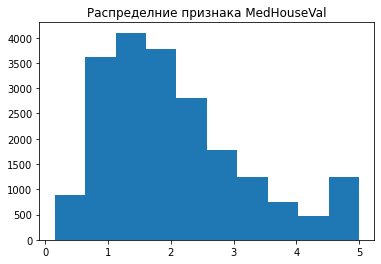

In [207]:
plt.hist(house_df['MedHouseVal'])
plt.title('Распределние признака MedHouseVal')
plt.show()

> Вывод: по данному графику можно сказать, что мы видим ненормальное распределение признаков. В данным присутствуют выбросы дома который находятся в ценовом диапазоне от 4.5 - 5.

## 4.  Матрица корреляций

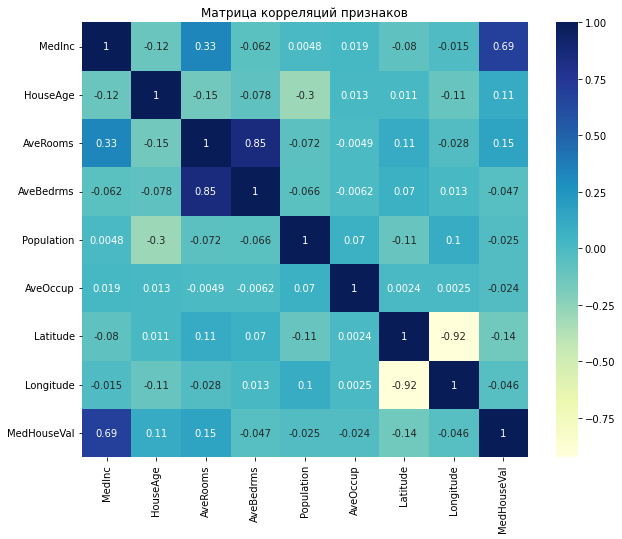

In [208]:
plt.figure(figsize=(10, 8))
sns.heatmap(house_df.corr(), cmap="YlGnBu", annot=True)
plt.title('Матрица корреляций признаков')
plt.show()

> Вывод: мы видим 4 признака имеющие между собой положительную корреляцию, так же есть 2 признака у который присутствует довольно высокая отрицательная корреляция

In [209]:
columns = [
    'MedInc',
    'AveRooms',
    'AveBedrms',
    'Latitude',
    'Longitude',
    'MedHouseVal'
]

In [210]:
result_df = pd.concat([result_df, get_metrics(house_df[columns], 'correaltion_model')])

## 5. Исследование на выбросы

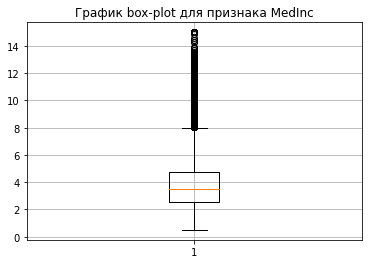

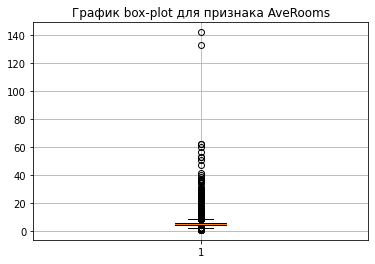

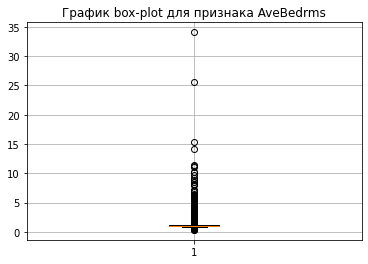

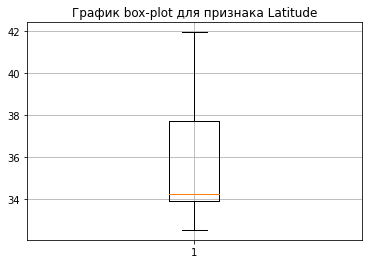

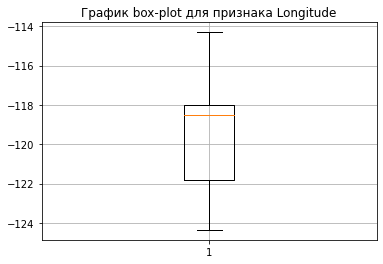

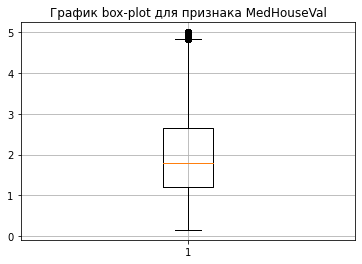

In [211]:
for column in columns:
    plt.grid()
    plt.boxplot(house_df[column])
    plt.title(f'График box-plot для признака {column}')
    plt.show()

> Как можно заметить у признаков обозначающих широту и долготу выбросов нет, а вот в других есть и их довольно много

### 5.1 Удаление выбросов

In [212]:
house_df = house_df[
    (house_df['MedInc'] <= 8) &
    ((house_df['AveRooms'] <= 10) & (house_df['AveRooms'] >= 2)) &
    ((house_df['AveBedrms'] >= 1) & (house_df['AveBedrms'] <= 2)) & 
    (house_df['MedHouseVal'] <= 4.7)
]

In [213]:
result_df = pd.concat([result_df, get_metrics(house_df, 'outlier_model')])

## 6. Преобразование признаков математически

In [214]:
columns_for_hist = ['MedInc', 'AveRooms', 'AveBedrms', 'MedHouseVal']

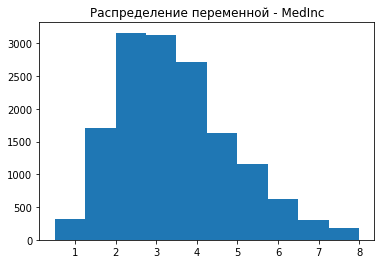

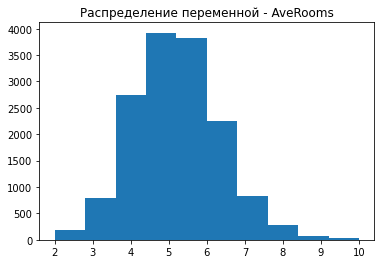

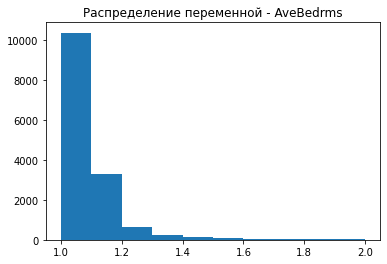

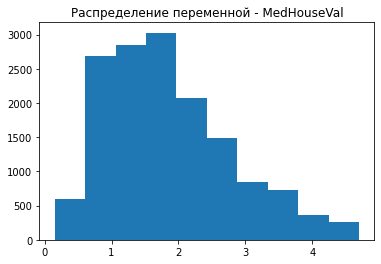

In [215]:
for column in columns_for_hist:
    plt.hist(house_df[column])
    plt.title(f'Распределение переменной - {column}')
    plt.show()

### 6.1 Логарифмирование

In [216]:
house_df['AveRooms'] = np.log(house_df['AveRooms'])

### 6.2 Извлечение корня

In [217]:
house_df['MedInc'] = np.sqrt(house_df['MedInc'])

### 6.3 Возведение в квадрат

In [218]:
house_df['AveBedrms'] = np.power(house_df['AveBedrms'], 2)

In [219]:
result_df = pd.concat([result_df, get_metrics(house_df, '1')])

## Выводы

In [220]:
result_df

,model_name,RMSE,R2,COLUMNS
0,default_model,0.555892,0.337670,"MedInc, HouseAge, AveRooms, AveBedrms, Populat..."
0,correaltion_model,0.566770,0.308695,"MedInc, AveRooms, AveBedrms, Latitude, Longitude"
0,outlier_model,0.388662,0.227721,"MedInc, HouseAge, AveRooms, AveBedrms, Populat..."
0,1,0.396345,0.194729,"MedInc, HouseAge, AveRooms, AveBedrms, Populat..."


> По итогам работы я обучил модель на 4 наборах данных.
1. Первый раз я обучил модель на данных, которые не подвергались обработке
2. Второй раз я обучил модель на данных, которые были отобранны с помощью матрицы корреляции.
3. Третья модель была обучена на данных из которых были удалены выбросы.
4. Последняя модель была обучена признаками который были преобразованны математически.

По моему мнению у меня получилось минимизировать метрику RMSE, но R2 score ухудшается.